<a href="https://colab.research.google.com/github/MortezaNosratpour/CPE-in-BNN/blob/main/FC_vs_BNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Harry24k/bayesian-neural-network-pytorch

Cloning into 'bayesian-neural-network-pytorch'...
remote: Enumerating objects: 286, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 286 (delta 6), reused 1 (delta 0), pack-reused 274
Receiving objects: 100% (286/286), 22.76 MiB | 15.80 MiB/s, done.
Resolving deltas: 100% (129/129), done.


In [2]:
!pip install torchbnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torchbnn
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

import numpy as np
import torchbnn as bnn
import math
import random
import matplotlib.pyplot as plt
from tqdm import tqdm


# Configuration and Hyperparameters

In [4]:
# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Hyper-parameters 
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 1
learning_rate = 0.001


# Load MNIST Dataset

In [5]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='/data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='/data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 80101941.57it/s]


Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40432474.57it/s]


Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24118191.44it/s]


Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7293464.31it/s]


Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw



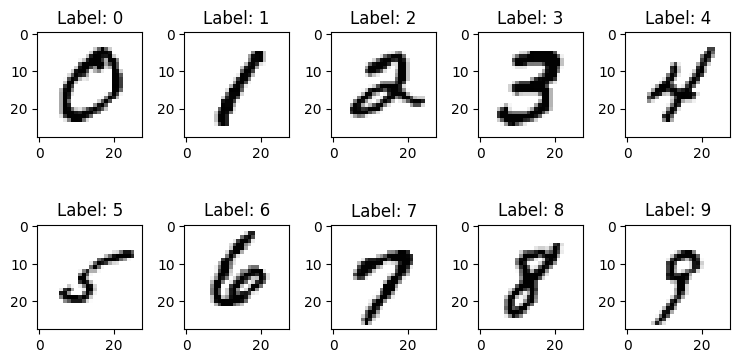

In [6]:
def plot_set_images(n_row, n_col, images, labels, label_text="Label: "):
  num=len(images)
  num_row=n_row
  num_col=n_col
  fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
  for i in range(num):
      ax = axes[i//num_col, i%num_col]
      ax.imshow(images[i].reshape(28, 28), cmap='gray_r')
      ax.set_title('{}{}'.format(label_text, labels[i]))
  plt.tight_layout()
  plt.show()

images_set = []
labels_set = []
j=0
for i in range(10):
  while i != train_dataset[j][1]:
    j += 1
  images_set.append(train_dataset[j][0])
  labels_set.append(train_dataset[j][1])
plot_set_images(2, 5, images_set, labels_set, "Label: ")

# Model Classes

In [7]:
# Fully connected neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [8]:
# Bayesian neural network
class BayesianNeuralNet(nn.Module):
      def __init__(self, input_size, hidden_size, num_classes):
        super(BayesianNeuralNet, self).__init__()
        self.fc1 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=input_size, out_features=hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=hidden_size, out_features=num_classes)  
    
      def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [9]:
fc_model = NeuralNet(input_size, hidden_size, num_classes).to(device)

In [10]:
bayes_model = BayesianNeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and Optimizers

In [11]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
fc_optimizer = torch.optim.Adam(fc_model.parameters(), lr=learning_rate)
bayes_optimizer = torch.optim.Adam(bayes_model.parameters(), lr=learning_rate) 
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)


# Train the Model

In [16]:
def model_trainer(model, criterion, optimizer, kl_loss=kl_loss, kl_weight = 0.01, bayesian=False):
  total_step = len(train_loader)
  losses = []
  cumulative_loss = 0
  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(train_loader):  
          # Move tensors to the configured device
          images = images.reshape(-1, 28*28).to(device)
          labels = labels.to(device)
          
          # Forward pass
          outputs = model(images)
          if not bayesian:
            loss = criterion(outputs, labels)
          else:
            loss = criterion(outputs, labels) + kl_weight*kl_loss(model)
            
          cumulative_loss += loss.item()

          # Backprpagation and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          if (i+1) % batch_size == 0:
              # print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
              #       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
              losses.append(cumulative_loss/batch_size)
              cumulative_loss = 0
      print ('Epoch [{}/{}], Average Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, np.array(losses[epoch*total_step:(epoch+1)*total_step]).mean()))
  
  return losses

In [43]:
def loss_plot(losses, x_label, y_label, title):
  k = len(losses)/1000
  tmp_losses = []

  for i in range(int(k)):
    tmp_losses.append(np.array(losses[i*1000:(i+1)*1000]).mean())


  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.plot(np.arange(1000, (len(tmp_losses)+1)*1000, 1000), np.array(tmp_losses))
  plt.show()

In [18]:
fc_losses = model_trainer(fc_model, criterion, fc_optimizer)

Epoch [1/5], Average Loss: 0.2143
Epoch [2/5], Average Loss: 0.1418
Epoch [3/5], Average Loss: 0.1276
Epoch [4/5], Average Loss: 0.1206
Epoch [5/5], Average Loss: 0.1000


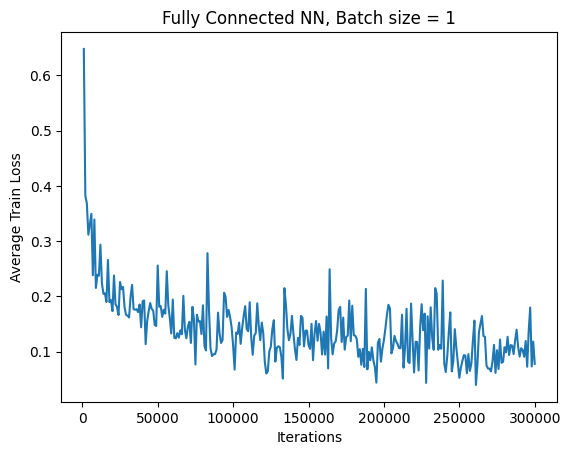

In [47]:
loss_plot(fc_losses, "Iterations", "Average Train Loss", "Fully Connected NN, Batch size = 1")

In [33]:
bayes_losses = model_trainer(bayes_model, criterion, bayes_optimizer, kl_weight=0.01, bayesian=True)

Epoch [1/5], Average Loss: 0.3557
Epoch [2/5], Average Loss: 0.2164
Epoch [3/5], Average Loss: 0.1952
Epoch [4/5], Average Loss: 0.1817
Epoch [5/5], Average Loss: 0.1675


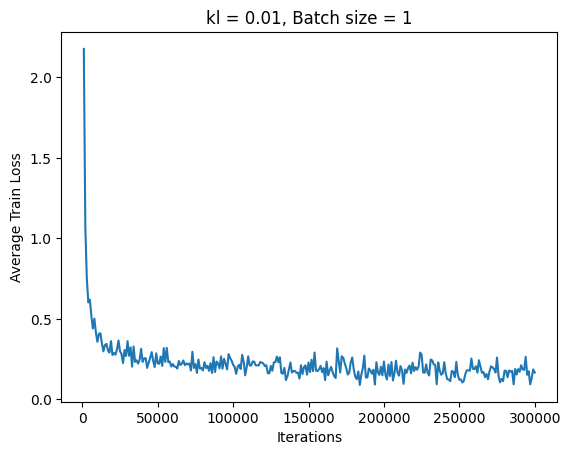

In [48]:
loss_plot(bayes_losses, "Iterations", "Average Train Loss","kl = 0.01, Batch size = 1")

In [35]:
high_kl_bayes_model = BayesianNeuralNet(input_size, hidden_size, num_classes).to(device)
hkl_bayes_losses = model_trainer(bayes_model, criterion, bayes_optimizer, kl_weight=0.5)

Epoch [1/5], Average Loss: 0.1355
Epoch [2/5], Average Loss: 0.1036
Epoch [3/5], Average Loss: 0.0975
Epoch [4/5], Average Loss: 0.0880
Epoch [5/5], Average Loss: 0.0774


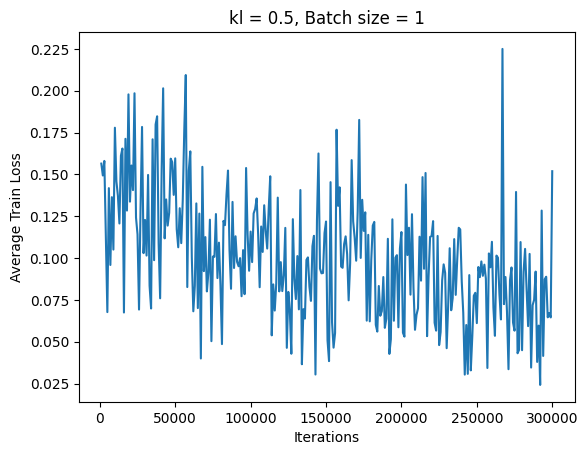

In [49]:
loss_plot(hkl_bayes_losses, "Iterations", "Average Train Loss","kl = 0.5, Batch size = 1")

# Test the Model

In [50]:
# In the test phase, don't need to compute gradients (for memory efficiency)
def model_tester(model, name):
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.reshape(-1, 28*28).to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      print('Accuracy of the' + name + 'network on the 10000 test images: {} %'.format(100 * correct / total))

  # Save the model checkpoint
  torch.save(model.state_dict(), str(name+'.ckpt'))

In [51]:
model_tester(fc_model, "FullyConnected")

Accuracy of theFullyConnectednetwork on the 10000 test images: 97.49 %


In [52]:
model_tester(bayes_model, "Bayesian_0.01")

Accuracy of theBayesian_0.01network on the 10000 test images: 97.36 %


In [53]:
model_tester(high_kl_bayes_model, "Bayesian_0.5")

Accuracy of theBayesian_0.5network on the 10000 test images: 9.96 %
